## Le code from scratch des optimizations

In [24]:
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_regression
from matplotlib import cm

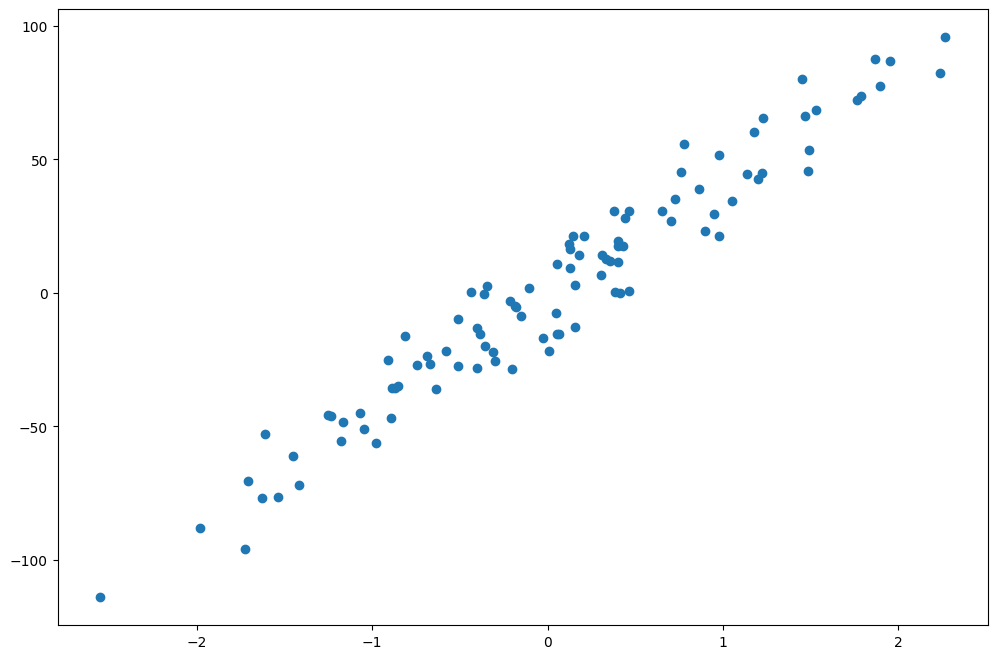

In [35]:
# Data pour la regression multiple
np.random.seed(0) # permet de reproduire l'aléatoire

X, Y = make_regression(n_samples=100, n_features=1, noise = 10) # creation d'un dataset (x, y) linéaire


plt.scatter(X, Y) # afficher les résultats. x en abscisse et y en ordonnée

In [36]:
# Creer la matrix X inclut le biais
X = np.hstack((X, np.ones(X.shape)))
# ajoute le vecteur x^2 a la gauche de la matrice X

print(X.shape)
print(X[:10])

(100, 2)
[[-0.35955316  1.        ]
 [ 0.97663904  1.        ]
 [ 0.40234164  1.        ]
 [-0.81314628  1.        ]
 [-0.88778575  1.        ]
 [ 0.44386323  1.        ]
 [-0.97727788  1.        ]
 [ 0.42833187  1.        ]
 [ 0.20827498  1.        ]
 [-0.31155253  1.        ]]


In [27]:
X.shape

(100, 3)

In [37]:
# Initialise theta
theta = np.random.rand(X.shape[1], 1)
theta

array([[0.27032791],
       [0.1314828 ]])

In [2]:
def model(X,theat):
    return np.dot(X,theat)

In [3]:
def grad(X, y, theta):
    m = len(y)
    return 1/m * X.T.dot(model(X, theta) - y)

La version *batch* consiste à mettre à jour la valeur de $\theta$ avec le gradient calculé sur l'ensemble des exemples. L'algorithme s'écrit :

Répéter jusqu'à convergence:

$$\theta_j := \theta_j + \frac{\alpha}{m} \sum_{i=1}^{m}(y^{(j)}-h_\theta(x^{(j)}))x^{(j)}_i$$

On peut implémenter l'algorithme *batch* de la façon suivante 

In [4]:
def batch_update(theta, X, Y, alpha=0.01):
    derivative = np.zeros_like(theta)
    m, n = X.shape
    for j in range(n):
        for i in range(m):
            derivative[j] += alpha * (Y[i] - model(X[i,:],theta)) * X[i,j]
    return theta + 1./m * derivative

Il est possible de réécrire cet algorithme de façon plus concise et plus efficice en utilisant une représentation matricielle :
$$\theta_j := \theta_j + \frac{\alpha}{m} (Y-X^T\theta) X$$

In [5]:
def batch_update(theta, X, Y, alpha=0.01):
    m, _ = X.shape
    # return theta + (alpha/m) * (Y - X.dot(theta)).dot(X)
    return theta + (alpha/m) * (Y - X @ theta) @ X

Il est également possible d'utiliser une version stochastique de la descente de gradient. Dans ce cas l'algorithme est mis à jour après chaque exemple, ce qui accèlere considérablement la convergence. Cependant l'algorithme *batch* converge de façon certaine vers l'optimum, qui est unique et global dans notre cas, alors que la version stochastique ne permet que de s'en approcher. L'algorithme stochastique s'écrit:

Répéter jusqu'à convergence:

Pour $i$ de 1 à $m$:

$\theta_j := \theta_j + \alpha (y^{(i)} - h_\theta (x^{(i)}) ) x^{(i)}_j $

In [7]:
def stochastic_update(theta, X, Y, alpha=0.01):
    new_theta = theta.copy()
    m = X.shape[0]
    for i in range(m):
        new_theta += alpha * (Y[i] - X[i,:] @ theta) * X[i,:]
    return new_theta

Il est également possible de dériver directement une solution qui minimise les moindres carrés:

\begin{equation}
\begin{split}
\nabla_\theta J(\theta) & = \nabla_\theta \frac{1}{2}(X\theta - y)^T(X\theta - y)\\
& = X^T X \theta - X^T y
\end{split}
\end{equation}

Pour trouver le minimum, on cherche le point om la dérivée s'annule:

$$ X^T X \theta = X^T y$$

et on ferme l'équation pour obtenir la valeur de $\theta$ qui minimise $J(\theta)$:

$$ \theta = (X^T X)^{-1} X^T y $$

Il est ainsi possible de calculer directement la valeur optimale de $\theta$ sans avoir besoin d'itérer une descente de gradient. Par contre cette solution requiert l'inversion d'une matrice, ce qui n'est envisageable que si la taille de $X$ est raisonnable (pas plus d'un millier d'échantillon). L'algorithme est le suivant:

In [8]:
# def normal_equation(X, Y):
#     # return pinv(X.T.dot(X)).dot(X.T).dot(Y)
#     return pinv(X.T @ X) @ X.T @ Y

In [11]:
def J(theta, X, Y):
    m = len(Y)
    predictions = X.dot(theta)
    return (1 / (2 * m)) * np.sum((predictions - Y) ** 2)

## Testons ces differentes approches et voir la difference entre elles

In [38]:
theta0_vals = np.linspace(-1, 1, 100)
theta1_vals = np.linspace(-0.1, 1.4, 100)
J_vals = np.zeros(shape=(theta0_vals.size, theta1_vals.size))
for t1, theta0 in enumerate(theta0_vals):
    for t2, theta1 in enumerate(theta1_vals):
        J_vals[t1, t2] = J(np.array([theta0, theta1]), X, Y)
J_vals = J_vals.T
theta_stoch=stochastic_update(theta, X, Y, alpha=0.01)
def plot_gradient(theta0_vals, theta1_vals, Z):
    levels = np.logspace(2, 8, 40)
    plt.set_cmap(cm.viridis)
    plt.contourf(theta0_vals, theta1_vals, Z, 40)
    cbar = plt.colorbar()
    cbar.set_label(r'$J(\theta)$')
    v = plt.axis()
    plt.contour(theta0_vals, theta1_vals, Z, 40, colors='k')
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')

plt.rcParams["figure.figsize"]=[12., 8.]
plot_gradient(theta0_vals, theta1_vals, J_vals)
_ = plt.scatter(theta_stoch[0], theta_stoch[1], c='k')

ValueError: non-broadcastable output operand with shape (2,1) doesn't match the broadcast shape (2,2)

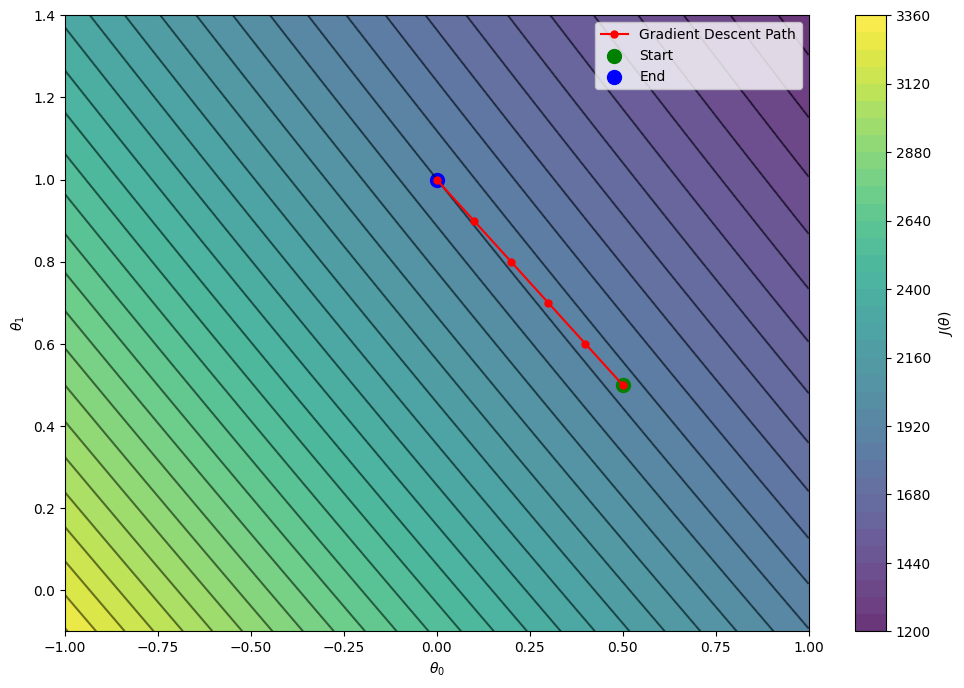

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Define the cost function J (example: mean squared error)


# Generate some data
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
Y = 4 + 3 * X + np.random.randn(100, 1)

# Add a column of ones to X for the bias term
X_b = np.c_[np.ones((100, 1)), X]

# Define the range for theta0 and theta1
theta0_vals = np.linspace(-1, 1, 100)
theta1_vals = np.linspace(-0.1, 1.4, 100)

# Compute the cost function J over the grid
J_vals = np.zeros((theta0_vals.size, theta1_vals.size))
for t1, theta0 in enumerate(theta0_vals):
    for t2, theta1 in enumerate(theta1_vals):
        J_vals[t1, t2] = J(np.array([theta0, theta1]), X_b, Y)
J_vals = J_vals.T

# Function to plot the gradient descent path
def plot_gradient(theta0_vals, theta1_vals, Z, theta_stoch):
    levels = np.logspace(2, 8, 40)
    plt.set_cmap(cm.viridis)
    plt.contourf(theta0_vals, theta1_vals, Z, 40, alpha=0.8)
    cbar = plt.colorbar()
    cbar.set_label(r'$J(\theta)$')
    plt.contour(theta0_vals, theta1_vals, Z, 40, colors='k', alpha=0.5)
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    
    # Plot the gradient descent path
    plt.plot(theta_stoch[:, 0], theta_stoch[:, 1], 'r-', marker='o', markersize=5, label='Gradient Descent Path')
    plt.scatter(theta_stoch[0, 0], theta_stoch[0, 1], c='g', s=100, label='Start')
    plt.scatter(theta_stoch[-1, 0], theta_stoch[-1, 1], c='b', s=100, label='End')
    plt.legend()

# Example gradient descent path (replace with your actual theta_stoch)
theta_stoch = np.array([[0.5, 0.5], [0.4, 0.6], [0.3, 0.7], [0.2, 0.8], [0.1, 0.9], [0.0, 1.0]])

# Plot the gradient descent path
plt.rcParams["figure.figsize"] = [12., 8.]
plot_gradient(theta0_vals, theta1_vals, J_vals, theta_stoch)
plt.show()

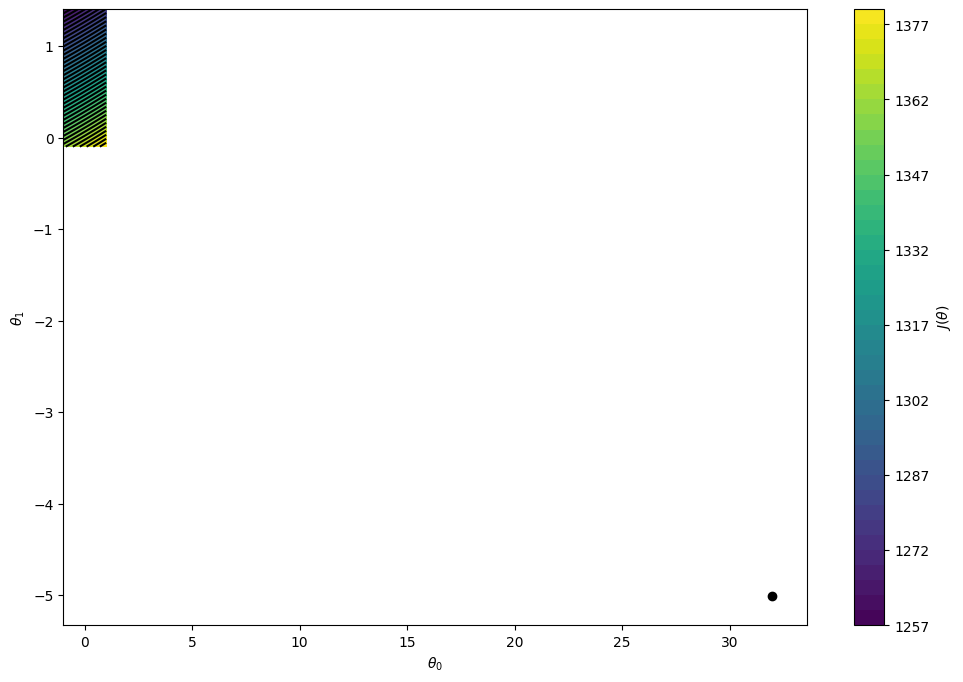

In [43]:

# Définir la fonction de coût J
def J(theta, X, Y):
    m = len(Y)
    predictions = X.dot(theta)
    cost = (1/(2*m)) * np.sum((predictions - Y)**2)
    return cost

# Définir la fonction de mise à jour stochastique
def stochastic_update(theta, X, Y, alpha):
    m = len(Y)
    for i in range(m):
        gradient = X[i].T.dot(X[i].dot(theta) - Y[i])
        theta = theta - alpha * gradient
    return theta

# Définir X, Y et theta
X, Y = make_regression(n_samples=100, n_features=1, noise = 10)
X = np.hstack((X, np.ones(X.shape)))

theta = np.array([0.0, 0.0])

# Générer les valeurs de theta0 et theta1
theta0_vals = np.linspace(-1, 1, 100)
theta1_vals = np.linspace(-0.1, 1.4, 100)
J_vals = np.zeros(shape=(theta0_vals.size, theta1_vals.size))

# Calculer les valeurs de J pour chaque combinaison de theta0 et theta1
for t1, theta0 in enumerate(theta0_vals):
    for t2, theta1 in enumerate(theta1_vals):
        J_vals[t1, t2] = J(np.array([theta0, theta1]), X, Y)

# Mettre à jour theta de manière stochastique
theta_stoch = stochastic_update(theta, X, Y, alpha=0.01)

# Définir la fonction pour tracer le gradient
def plot_gradient(theta0_vals, theta1_vals, Z):
    levels = np.logspace(2, 8, 40)
    plt.set_cmap(cm.viridis)
    plt.contourf(theta0_vals, theta1_vals, Z, 40)
    cbar = plt.colorbar()
    cbar.set_label(r'$J(\theta)$')
    v = plt.axis()
    plt.contour(theta0_vals, theta1_vals, Z, 40, colors='k')
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')

# Tracer le gradient
plt.rcParams["figure.figsize"] = [12., 8.]
plot_gradient(theta0_vals, theta1_vals, J_vals)
_ = plt.scatter(theta_stoch[0], theta_stoch[1], c='k')
plt.show()

####  A revoir